## Librerías 

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2.14.0


## Datos

In [6]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/data/Materiales/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[5]
    number = ruta_list[6]
    tipo = ruta_list[7]
    name = ruta_list[8].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1,random_state=42)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 923
MF1: 378
MF2: 284
MF3: 261


/tmp/ipykernel_40768/1069059928.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  routes_dataset['label'].replace(char_to_num,inplace=True)


,name,route_image,label,number,route_mask
324,IMG_20230707_180522_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,5,/data/Materiales/Micrografías segmentaciones/s...
867,IMG_20230711_214815_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,6,/data/Materiales/Micrografías segmentaciones/s...
31,IMG_20230602_210322_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,3,/data/Materiales/Micrografías segmentaciones/s...
843,IMG_20230711_212848_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,7,/data/Materiales/Micrografías segmentaciones/s...
295,IMG_20230707_174047_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,4,/data/Materiales/Micrografías segmentaciones/s...
...,...,...,...,...,...
107,IMG_20230707_161853_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,1,/data/Materiales/Micrografías segmentaciones/s...
271,IMG_20230707_173655_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,4,/data/Materiales/Micrografías segmentaciones/s...
866,IMG_20230711_214812_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,6,/data/Materiales/Micrografías segmentaciones/s...
436,IMG_20230707_191401_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,7,/data/Materiales/Micrografías segmentaciones/s...


In [7]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


In [9]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')           

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter), npores]
        
        descriptors.append(descriptor)
        
    
    return descriptors

def create_dataset(buffer,file_names, labels, file_mask): 
  ## Get binary images   
  masks = get_binary_image(file_mask)
  ## Get geometric atributes from binary images
  attributes = get_geometric_atributes(masks)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

file_names = train_df['route_image'].to_numpy()
file_mask = train_df['route_mask'].to_numpy()
labels = train_df['label'].to_numpy()
## Create training dataset using tf.data of 16 images
dataset = create_dataset(16,file_names, labels,file_mask)

2024-09-03 02:24:32.562822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7118 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:1a:00.0, compute capability: 8.6


[174.28571429  52.56215173  13.65660088  35.        ]
b'0'


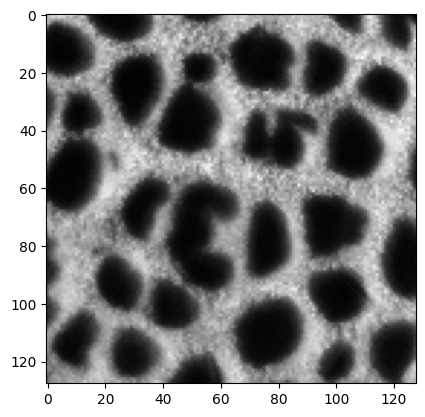

In [10]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]
    #d = i[3]

n =  0
print(c[n].numpy())
print(b[n].numpy())
plt.imshow(a[n],cmap='gray')
#plt.imshow(d[n],cmap='gray')
plt.show()

In [12]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].route_image
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

Test: train-> (183, 128, 128, 1)  test -> (183,)


In [13]:
x_test_secas = np.array(X_test_secas)
x_test_secas= x_test_secas.astype('float32')
 
#y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

Number of images in x_test (183, 128, 128, 1) y_test:  (183,)


In [14]:
x_train = []
y_train_ten = []
for data,label,attributes in dataset.batch(8):
    x_train.extend(data[:].numpy())
    y_train_ten.extend(label)   

x_train = np.array(x_train)
x_train = x_train.astype('float32')

y_train= []
for i in y_train_ten:
    y_train.append(str(int(i)))

print(np.shape(x_train),np.shape(y_train))

(740, 128, 128, 1) (740,)


## Modelo

In [15]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [16]:
encoder = keras.models.load_model('Models2/weakly_disc_deep_GVAE_encoder_DRY_2_16.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models2/weakly_disc_deep_GVAE_decoder_DRY_2_16.h5', custom_objects={'Sampling':Sampling})

## Clasificación

In [17]:
data_train = x_train
data_test = x_test_secas

label_train = y_train
label_test = y_test_secas

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (740, 128, 128, 1) (740,)
Test:  (183, 128, 128, 1) (183,)


2024-09-03 02:26:46.276555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


24/24 [==============================] - 1s 10ms/step
Shape_embs:  (3, 740, 16)
6/6 [==============================] - 0s 31ms/step
Shape_embs:  (3, 183, 16)


In [18]:
char_to_num_new = {'0':0,'1':1,'2':2}
print(char_to_num_new)
print(np.shape(tf.keras.utils.to_categorical(label_train)))

{'0': 0, '1': 1, '2': 2}
(740, 3)


In [19]:
## Embebidos
#--- Train
media_train = encoder_embds[0]
variance_train = encoder_embds[1]
z_train = encoder_embds[2]

#--- Test
media_test = encoder_embds_test[0]
variance_test = encoder_embds_test[1]
z_test = encoder_embds_test[2]

#--- labels
#labels_text_test
#labels_text
#images_df['label'].replace(char_to_num,inplace=True)

data_embs_train = pd.DataFrame()
data_embs_train ['mean'] =  media_train.tolist()
data_embs_train ['var'] =  variance_train.tolist()
data_embs_train ['z'] =  z_train.tolist()
data_embs_train ['labels'] = list(pd.DataFrame(label_train).replace(char_to_num_new).values.reshape(-1))

data_embs_test = pd.DataFrame()
data_embs_test ['mean'] =  media_test.tolist()
data_embs_test ['var'] =  variance_test.tolist()
data_embs_test ['z'] =  z_test.tolist()
data_embs_test ['labels'] = list(pd.DataFrame(label_test).replace(char_to_num_new).values.reshape(-1))

/tmp/ipykernel_40768/2868859371.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_embs_train ['labels'] = list(pd.DataFrame(label_train).replace(char_to_num_new).values.reshape(-1))
/tmp/ipykernel_40768/2868859371.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_embs_test ['labels'] = list(pd.DataFrame(label_test).replace(char_to_num_new).values.reshape(-1))


### Decision trees

In [20]:
## Embebido
estist = 'z'

max:  0.864327485380117  - depth:  185
accuracy 0.830 (+/- 0.06808)


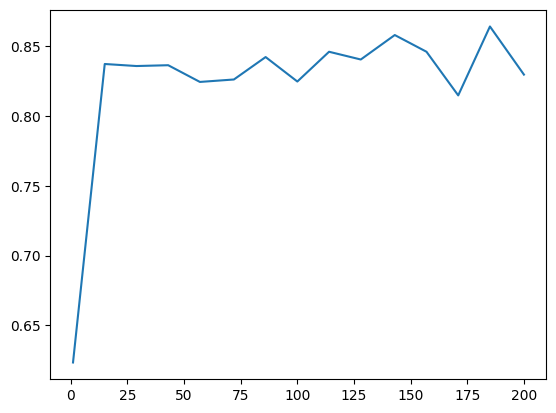

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est_DT_mean = DecisionTreeClassifier(max_depth=d,random_state=42)

    x = list(data_embs_test[estist].values)
    y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))

    s = cross_val_score(est_DT_mean, x,y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

print('max: ',np.max(acs),' - depth: ',dpst[np.argmax(acs)])
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)
plt.show()

In [22]:
x_DT_train = list(data_embs_train[estist].values)
y_DT_train = tf.keras.utils.to_categorical(list(data_embs_train['labels'].values))
est_DT_mean = DecisionTreeClassifier(max_depth=np.argmax(acs),random_state=42)
est_DT_mean.fit(x_DT_train ,y_DT_train)

x = list(data_embs_test[estist].values)
y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))
y_predicted = est_DT_mean.predict(x)

target_names = ['MF1', 'MF2', 'MF3']
print(classification_report(y, y_predicted,target_names=target_names))

              precision    recall  f1-score   support

         MF1       0.81      0.93      0.87        75
         MF2       0.73      0.73      0.73        56
         MF3       0.98      0.77      0.86        52

   micro avg       0.83      0.83      0.83       183
   macro avg       0.84      0.81      0.82       183
weighted avg       0.83      0.83      0.82       183
 samples avg       0.83      0.83      0.83       183



### Random forest

max:  0.885672514619883  - depth:  128
accuracy 0.880 (+/- 0.04544)


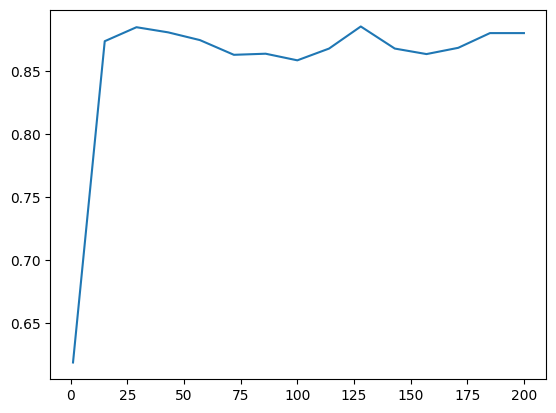

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est_RF_mean = RandomForestClassifier(max_depth=d,random_state=42)

    x = list(data_embs_test[estist].values)
    y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))

    s = cross_val_score(est_RF_mean, x,y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    
print('max: ',np.max(acs),' - depth: ',dpst[np.argmax(acs)])
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

In [24]:
x_RF_train = list(data_embs_train[estist].values)
y_RF_train = tf.keras.utils.to_categorical(list(data_embs_train['labels'].values))
est_RF_mean = RandomForestClassifier(max_depth=dpst[np.argmax(acs)],random_state=42)
est_RF_mean.fit(x_RF_train ,y_RF_train)

x = list(data_embs_test[estist].values)
y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))
y_predicted = est_RF_mean.predict(x)

target_names = ['MF1', 'MF2', 'MF3']
print(classification_report(y, y_predicted,target_names=target_names))

              precision    recall  f1-score   support

         MF1       0.88      0.95      0.91        75
         MF2       0.78      0.80      0.79        56
         MF3       1.00      0.83      0.91        52

   micro avg       0.87      0.87      0.87       183
   macro avg       0.88      0.86      0.87       183
weighted avg       0.88      0.87      0.87       183
 samples avg       0.87      0.87      0.87       183



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### KNN

0.8797814207650273


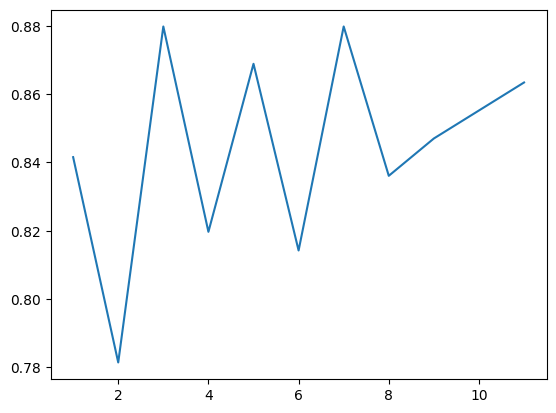

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,11,10, dtype=int):
    knn_mean = KNeighborsClassifier(n_neighbors = d)


    x = list(data_embs_train[estist].values)
    y = tf.keras.utils.to_categorical(data_embs_train['labels'].values)


    knn_mean.fit(x,y)

    y_pred = knn_mean.predict(list(data_embs_test[estist].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(tf.keras.utils.to_categorical(data_embs_test['labels'].values)
, y_pred))
    dst.append(d)

print(np.max(scs))
plt.plot(dst,scs)    

In [26]:
x_KNN_train = list(data_embs_train[estist].values)
y_KNN_train = tf.keras.utils.to_categorical(list(data_embs_train['labels'].values))
est_KNN_mean = KNeighborsClassifier(n_neighbors = dpst[np.argmax(acs)])
est_KNN_mean.fit(x_KNN_train ,y_KNN_train)

x = list(data_embs_test[estist].values)
y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))
y_predicted = est_KNN_mean.predict(x)

target_names = ['MF1', 'MF2', 'MF3']
print(classification_report(y, y_predicted,target_names=target_names))

              precision    recall  f1-score   support

         MF1       0.90      0.87      0.88        75
         MF2       0.73      0.86      0.79        56
         MF3       1.00      0.85      0.92        52

   micro avg       0.86      0.86      0.86       183
   macro avg       0.88      0.86      0.86       183
weighted avg       0.88      0.86      0.86       183
 samples avg       0.86      0.86      0.86       183



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
